## Conjunto de dados

In [1]:
# Bibliotecas
import os
import re
import unicodedata
import zipfile

import matplotlib.pyplot as plt
import nltk
import pandas as pd
import requests
import spacy
from tqdm.notebook import tqdm

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from itertools import chain
from spacy import displacy

In [2]:
# Clona o repositório
!git clone https://github.com/Jade16/pln.git

Cloning into 'pln'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 45 (delta 17), reused 38 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (45/45), 35.59 MiB | 11.94 MiB/s, done.
Resolving deltas: 100% (17/17), done.


In [3]:
# Caminho do dataset
zip_path = "/content/pln/b2w.csv.zip"

In [4]:
# Extraí o arquivo zip
with zipfile.ZipFile(zip_path) as z:
    z.extractall()
    csv_name = next(f for f in z.namelist() if f.endswith(".csv"))

In [5]:
# Dataframe do conjunto de dados
df = pd.read_csv(csv_name)
df

,original_index,review_text,review_text_processed,review_text_tokenized,polarity,rating,kfold_polarity,kfold_rating
0,11955,Bem macio e felpudo...recomendo. Preço imbatí...,bem macio e felpudo...recomendo. preco imbati...,"['bem', 'macio', 'felpudo', 'recomendo', 'prec...",1.0,4,1,1
1,35478,Produto excepcional! recomendo!!! inovador e ...,produto excepcional! recomendo!!! inovador e ...,"['produto', 'excepcional', 'recomendo', 'inova...",1.0,5,1,1
2,122760,recebi o produto antes do prazo mas veio com d...,recebi o produto antes do prazo mas veio com d...,"['recebi', 'produto', 'antes', 'do', 'prazo', ...",0.0,1,1,1
3,17114,Bom custo beneficio. Adequado para pessoas que...,bom custo beneficio. adequado para pessoas que...,"['bom', 'custo', 'beneficio', 'adequado', 'par...",1.0,5,1,1
4,19112,Além de higiênico tem o tamanho ideal. Só falt...,alem de higienico tem o tamanho ideal. so falt...,"['alem', 'de', 'higienico', 'tem', 'tamanho', ...",NaN,3,-1,1
...,...,...,...,...,...,...,...,...
132368,41993,SMARTHPHONE PERFEITO MUITO BOM E A ECONO...,smarthphone perfeito muito bom e a econo...,"['smarthphone', 'perfeito', 'muito', 'bom', 'e...",1.0,5,10,10
132369,97639,Eu estou muito chateado com isso gostaria que ...,eu estou muito chateado com isso gostaria que ...,"['eu', 'estou', 'muito', 'chateado', 'com', 'i...",0.0,1,10,10
132370,95939,"Vale a pena pelo preço oferecido, qualidade a ...","vale a pena pelo preco oferecido, qualidade a ...","['vale', 'pena', 'pelo', 'preco', 'oferecido',...",NaN,3,-1,10
132371,117952,O produto anunciado no site dizia ser 100% al...,o produto anunciado no site dizia ser 100% al...,"['produto', 'anunciado', 'no', 'site', 'dizia'...",0.0,1,10,10


In [7]:
# Informações de valores nulos e tipo de dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132373 entries, 0 to 132372
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   original_index         132373 non-null  int64  
 1   review_text            132373 non-null  object 
 2   review_text_processed  132373 non-null  object 
 3   review_text_tokenized  132373 non-null  object 
 4   polarity               116058 non-null  float64
 5   rating                 132373 non-null  int64  
 6   kfold_polarity         132373 non-null  int64  
 7   kfold_rating           132373 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 8.1+ MB


In [47]:
# Estatística descritiva
df.describe()

,original_index,polarity,rating,kfold_polarity,kfold_rating,review_length
count,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000
mean,66160.886841,0.691895,3.561168,5.499931,5.499974,23.794198
std,38210.653685,0.461712,1.622398,2.872270,2.872285,23.879621
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,33137.250000,0.000000,2.000000,3.000000,3.000000,11.000000
50%,66153.500000,1.000000,4.000000,5.000000,5.500000,16.000000
75%,99256.750000,1.000000,5.000000,8.000000,8.000000,27.000000
max,132372.000000,1.000000,5.000000,10.000000,10.000000,696.000000


## Análise Exploratória dos Dados

In [9]:
# Valores Ausentes
df.isnull().sum()

,0
original_index,0
review_text,0
review_text_processed,0
review_text_tokenized,0
polarity,16315
rating,0
kfold_polarity,0
kfold_rating,0


In [10]:
# Remove linhas onde 'polarity' possui valores ausentes
df = df.dropna(subset=["polarity"]).reset_index(drop=True)

In [11]:
# Estatísticas descritivas de 'Polarity' e 'Rating'
df[['polarity', 'rating']].describe()

,polarity,rating
count,116058.000000,116058.000000
mean,0.691895,3.561168
std,0.461712,1.622398
min,0.000000,1.000000
25%,0.000000,2.000000
50%,1.000000,4.000000
75%,1.000000,5.000000
max,1.000000,5.000000


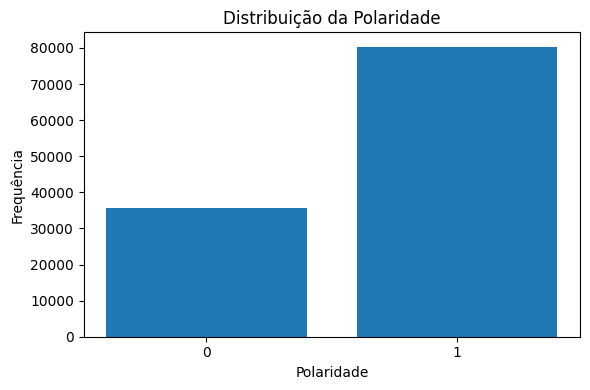

array([1., 0.])

In [14]:
# Distribuição da polaridade no conjunto de dados
plt.figure(figsize=(6,4))
polarity_counts = df['polarity'].value_counts().sort_index()
plt.bar(polarity_counts.index, polarity_counts.values)
plt.title('Distribuição da Polaridade')
plt.xlabel('Polaridade')
plt.ylabel('Frequência')
plt.xticks(polarity_counts.index)
plt.tight_layout()
plt.show()

df["polarity"].unique()

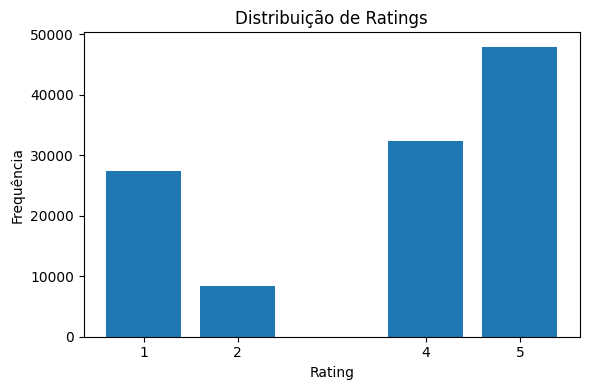

array([4, 5, 1, 2])

In [16]:
# Distribuição da nota no conjunto de dados
plt.figure(figsize=(6,4))
rating_counts = df['rating'].value_counts().sort_index()
plt.bar(rating_counts.index, rating_counts.values)
plt.title('Distribuição de Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequência')
plt.xticks(rating_counts.index)
plt.tight_layout()
plt.show()

df["rating"].unique()

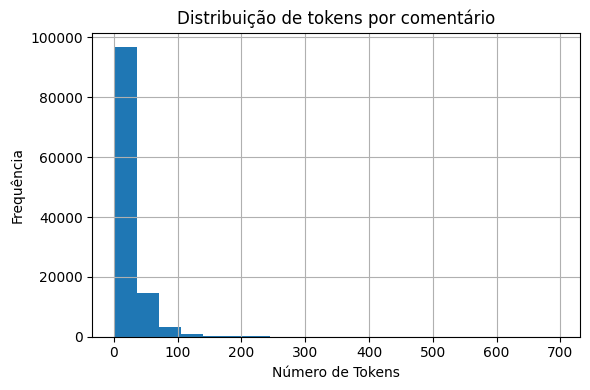

In [17]:
# Número de tokens
df['review_length'] = df['review_text_processed'].str.split().apply(len)

plt.figure(figsize=(6,4))
df['review_length'].hist(bins=20)
plt.title('Distribuição de tokens por comentário')
plt.xlabel('Número de Tokens')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()

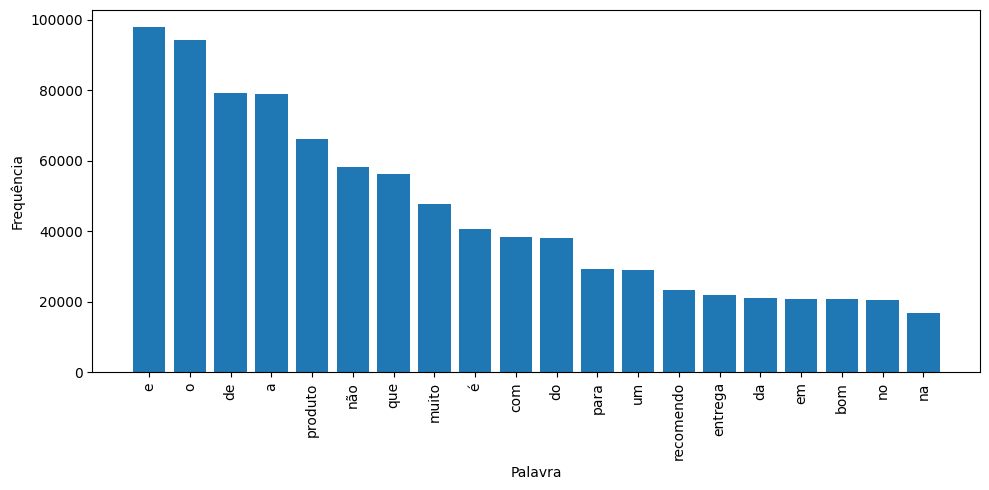

In [18]:
# Palavras mais comuns no conjunto de dados

# Tokeniza e concatena
all_text = " ".join(df['review_text'].astype(str))
tokens = re.findall(r'\b\w+\b', all_text.lower(), flags=re.UNICODE)

word_counts = Counter(tokens)
top_words = word_counts.most_common(20) # Seleciona 20
words, counts = zip(*top_words)

# Gráfico de barras
plt.figure(figsize=(10,5))
plt.bar(words, counts)
plt.xticks(rotation=90)
plt.xlabel('Palavra')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()

Na imagem acima podemos perceber vários stopwords.

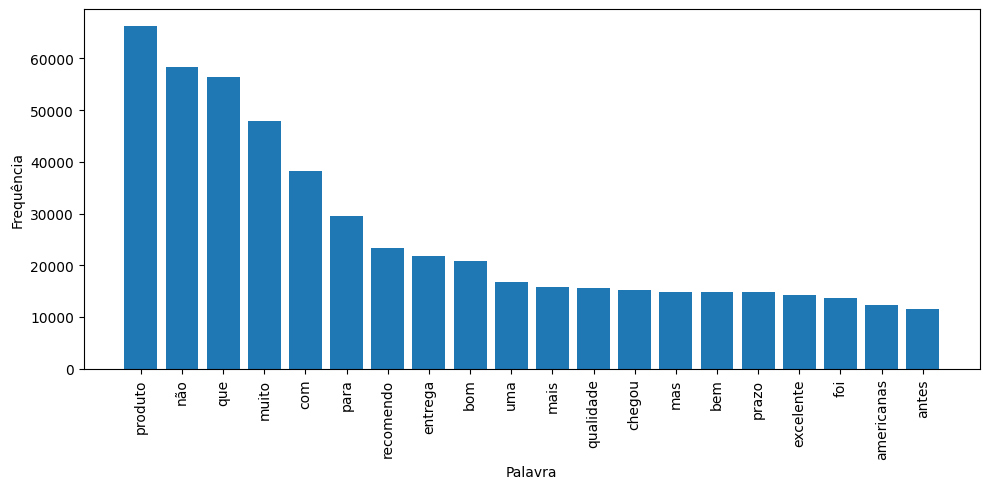

In [35]:
# Palavras mais comuns acima de 3 caracteres

# Tokeniza e concatena
all_text = " ".join(df['review_text'].astype(str))
tokens = re.findall(r'\b\w{3,}\b', all_text.lower(), flags=re.UNICODE)

word_counts = Counter(tokens)
top_words = word_counts.most_common(20)  # Seleciona as 20 mais comuns
words, counts = zip(*top_words)

# Gráfico de barras
plt.figure(figsize=(10,5))
plt.bar(words, counts)
plt.xticks(rotation=90)
plt.xlabel('Palavra')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()

In [22]:
# Palavras menos comuns no conjunto de dados
least_common = sorted(word_counts.items(), key=lambda x: x[1])[:20] # Seleciona 20
words_l, counts_l = zip(*least_common)

for w, c in least_common:
    print(f"{w}: {c}")

ótmo: 1
hog: 1
07172200: 1
carrodemola: 1
telivisao: 1
autuofalante: 1
k33b37: 1
primários: 1
penae: 1
flequixivel: 1
roboram: 1
9ª: 1
uníco: 1
577: 1
frustados: 1
removedores: 1
camioneta: 1
maú: 1
basa: 1
b2b: 1


## Pré-processamento dos Dados

In [23]:
# Biblioteca de stopwords para pt
nltk.download("stopwords")
stop_pt = set(stopwords.words("portuguese"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [25]:
# Padronização e limpeza dos dados
def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r"[^a-zà-ÿ\s]", " ", text)   # remove pontuação/números
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["review_text_clean"] = df["review_text"].astype(str).apply(clean_text)
df[["review_text", "review_text_clean"]].head()

,review_text,review_text_clean
0,Bem macio e felpudo...recomendo. Preço imbatí...,bem macio e felpudo recomendo preço imbatível ...
1,Produto excepcional! recomendo!!! inovador e ...,produto excepcional recomendo inovador e gosto...
2,recebi o produto antes do prazo mas veio com d...,recebi o produto antes do prazo mas veio com d...
3,Bom custo beneficio. Adequado para pessoas que...,bom custo beneficio adequado para pessoas que ...
4,"ótmo produto atendeu as expectativas, a entreg...",ótmo produto atendeu as expectativas a entrega...


In [28]:
# Tokenização
def tokenize(text: str):
    return text.split()

df["review_text_tokenized"] = df["review_text_clean"].apply(tokenize)
df[["review_text", "review_text_tokenized"]].head() # Tirar e atualizar a tabela depois

,review_text,review_text_tokenized
0,Bem macio e felpudo...recomendo. Preço imbatí...,"[bem, macio, e, felpudo, recomendo, preço, imb..."
1,Produto excepcional! recomendo!!! inovador e ...,"[produto, excepcional, recomendo, inovador, e,..."
2,recebi o produto antes do prazo mas veio com d...,"[recebi, o, produto, antes, do, prazo, mas, ve..."
3,Bom custo beneficio. Adequado para pessoas que...,"[bom, custo, beneficio, adequado, para, pessoa..."
4,"ótmo produto atendeu as expectativas, a entreg...","[ótmo, produto, atendeu, as, expectativas, a, ..."


In [29]:
# Remove stopwords
def remove_stopwords(tokens):
    return [tok for tok in tokens if tok not in stop_pt and len(tok) > 1]

df["review_text_nostop"] = df["review_text_tokenized"].apply(remove_stopwords)
df[["review_text", "review_text_nostop"]].head()

,review_text,review_text_nostop
0,Bem macio e felpudo...recomendo. Preço imbatí...,"[bem, macio, felpudo, recomendo, preço, imbatí..."
1,Produto excepcional! recomendo!!! inovador e ...,"[produto, excepcional, recomendo, inovador, go..."
2,recebi o produto antes do prazo mas veio com d...,"[recebi, produto, antes, prazo, veio, defeito,..."
3,Bom custo beneficio. Adequado para pessoas que...,"[bom, custo, beneficio, adequado, pessoas, faz..."
4,"ótmo produto atendeu as expectativas, a entreg...","[ótmo, produto, atendeu, expectativas, entrega..."


In [30]:
# Visualização das novas colunas
df[["review_text", "review_text_clean", "review_text_tokenized", "review_text_nostop"]].head()

,review_text,review_text_clean,review_text_tokenized,review_text_nostop
0,Bem macio e felpudo...recomendo. Preço imbatí...,bem macio e felpudo recomendo preço imbatível ...,"[bem, macio, e, felpudo, recomendo, preço, imb...","[bem, macio, felpudo, recomendo, preço, imbatí..."
1,Produto excepcional! recomendo!!! inovador e ...,produto excepcional recomendo inovador e gosto...,"[produto, excepcional, recomendo, inovador, e,...","[produto, excepcional, recomendo, inovador, go..."
2,recebi o produto antes do prazo mas veio com d...,recebi o produto antes do prazo mas veio com d...,"[recebi, o, produto, antes, do, prazo, mas, ve...","[recebi, produto, antes, prazo, veio, defeito,..."
3,Bom custo beneficio. Adequado para pessoas que...,bom custo beneficio adequado para pessoas que ...,"[bom, custo, beneficio, adequado, para, pessoa...","[bom, custo, beneficio, adequado, pessoas, faz..."
4,"ótmo produto atendeu as expectativas, a entreg...",ótmo produto atendeu as expectativas a entrega...,"[ótmo, produto, atendeu, as, expectativas, a, ...","[ótmo, produto, atendeu, expectativas, entrega..."


## Análise Morfossintática

In [31]:
# Biblioteca de PLN em pt
!python -m spacy download pt_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 85.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [38]:
# Carrega o modelo
nlp = spacy.load("pt_core_news_sm")

In [44]:
# Função p/ identificar as classes gramaticais - Universal POS tags
def pos_tag_text(text):
    doc = nlp(text)
    return [(tok.text, tok.pos_) for tok in doc]

In [49]:
# Gera as classes gramaticais de cada palavra e add uma coluna no df
tqdm.pandas(desc="Gerando POS‑tags")

df["pos_tags"] = df["review_text"].progress_apply(pos_tag_text) # Para ver os dados limpos (sem pontuações) usar review_text_clean

Gerando POS‑tags:   0%|          | 0/116058 [00:00<?, ?it/s]

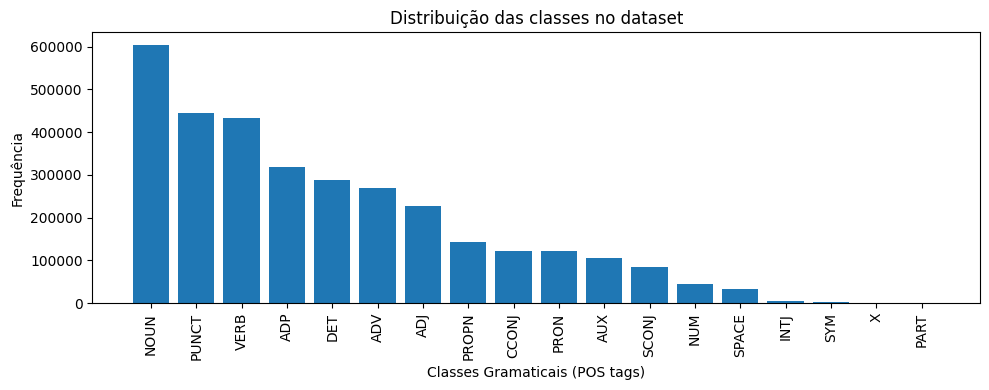

In [50]:
# Calcula a frequência das classes gramaticais
all_tags = list(chain.from_iterable((tag for _, tag in sent)for sent in df["pos_tags"]))
tag_counts = Counter(all_tags)
total_tokens = sum(tag_counts.values())

tag_df = (pd.DataFrame(
            [(tag, freq, freq/total_tokens*100) for tag, freq in tag_counts.items()],
            columns=["POS", "Freq", "Percent"]).sort_values("Freq", ascending=False).reset_index(drop=True))


# Plota o gráfico
num = len(tag_df)

plt.figure(figsize=(10,4))
plt.bar(tag_df["POS"][:num], tag_df["Freq"][:num])
plt.title(f"Distribuição das classes no dataset")
plt.ylabel("Frequência")
plt.xlabel("Classes Gramaticais (POS tags)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [51]:
# Demostração no conjunto de dados
sample_idx = [1, 2, 3]  # Índices do dataset
for _, row in df.loc[sample_idx].iterrows():
    print(f'Texto: {row["review_text_clean"]}')
    df_tags = pd.DataFrame(row["pos_tags"], columns=["Palavra", "Classe"])
    print(df_tags.to_string(index=False))
    print("-" * 70)

Texto: produto excepcional recomendo inovador e gostoso de ler
    Palavra Classe
    Produto   NOUN
excepcional    ADJ
          !  PUNCT
             SPACE
  recomendo   NOUN
          !  PUNCT
          !  PUNCT
          !  PUNCT
   inovador    ADJ
          e  CCONJ
    gostoso    ADJ
         de  SCONJ
        ler   VERB
          !  PUNCT
          !  PUNCT
----------------------------------------------------------------------
Texto: recebi o produto antes do prazo mas veio com defeito na trava ou seja não da para usar e até agora a americanas não resolveu e preciso muito deste produto
   Palavra Classe
    recebi   VERB
         o    DET
   produto   NOUN
     antes    ADV
        do    ADP
     prazo   NOUN
       mas  CCONJ
      veio   VERB
       com    ADP
   defeito   NOUN
        na    ADP
     trava   VERB
        ou  CCONJ
      seja    AUX
       não    ADV
        da   PRON
      para  SCONJ
      usar   VERB
         e  CCONJ
       até    ADP
     agora    ADV
    

In [52]:
# Filtra um comentário específico
sample_row = df[df["original_index"] == 85726]

for _, row in sample_row.iterrows():
    print(f'Texto: {row["review_text"]}')
    df_tags = pd.DataFrame(row["pos_tags"], columns=["Palavra", "Classe"])
    print(df_tags.to_string(index=False))
    print("-" * 70)

Texto: Exatamente o que eu estava esperando e entrega no prazo
   Palavra Classe
Exatamente    ADV
         o   PRON
       que   PRON
        eu   PRON
    estava    AUX
 esperando   VERB
         e  CCONJ
   entrega   VERB
        no    ADP
     prazo   NOUN
----------------------------------------------------------------------


In [54]:
# Input do usuário
def analyze_sentence(text):
    pos_tags = pos_tag_text(text)
    df_tags = pd.DataFrame(pos_tags, columns=["Palavra", "Classe"])

    print(f'Texto: {text.strip()}')
    print(df_tags.to_string(index=False))

analyze_sentence(input("Digite uma frase:\n "))

Digite uma frase:
 É bem difícil de conseguir treinar essa solução.
Texto: É bem difícil de conseguir treinar essa solução.
  Palavra Classe
        É    AUX
      bem    ADV
  difícil    ADJ
       de  SCONJ
conseguir   VERB
  treinar   VERB
     essa    DET
  solução   NOUN
        .  PUNCT


## Análise sintatíca

In [64]:
# Parsing da dependência sintática
def dep_parse_text(text):
    doc = nlp(text)
    return [(tok.text, tok.pos_, tok.dep_, tok.head.text) for tok in doc]

In [65]:
# Gera rótulos de dependência de cada palavra e add uma coluna no df
tqdm.pandas(desc="Análise sintática")
df["deps"] = df["review_text_clean"].progress_apply(dep_parse_text) # Para ver os dados brutos usar review_text

Análise sintática:   0%|          | 0/116058 [00:00<?, ?it/s]

In [71]:
# Calcula a frequência das dependências sintáticas
all_deps = list(chain.from_iterable((dep for _, _, dep, _ in sent) for sent in df["deps"]))
dep_counts = Counter(all_deps)
total_deps = sum(dep_counts.values())

dep_df = (pd.DataFrame(
            [(d, f, f/total_deps*100) for d, f in dep_counts.items()],
            columns=["Dep", "Freq", "Percent"]).sort_values("Freq", ascending=False).reset_index(drop=True))

In [72]:
# Lista todas as dependências sintáticas da biblioteca
dep_list = sorted(dep_counts.items(), key=lambda x: x[1], reverse=True)

for dep, freq in dep_list:
    print(f"{dep} - {freq}")

case - 315766
det - 286698
advmod - 265898
obj - 219345
amod - 188712
nsubj - 171724
conj - 155265
nmod - 144848
obl - 143402
ROOT - 129216
cc - 126653
mark - 95709
xcomp - 88780
advcl - 80391
cop - 71606
acl - 45514
ccomp - 40064
acl:relcl - 31977
aux - 23832
fixed - 18432
csubj - 15089
aux:pass - 13377
dep - 10155
appos - 9244
nsubj:pass - 8145
nummod - 8072
flat:name - 7260
parataxis - 6613
expl - 5792
iobj - 4804
obl:agent - 2980
punct - 1454
compound - 1333
discourse - 305
flat - 267
flat:foreign - 249


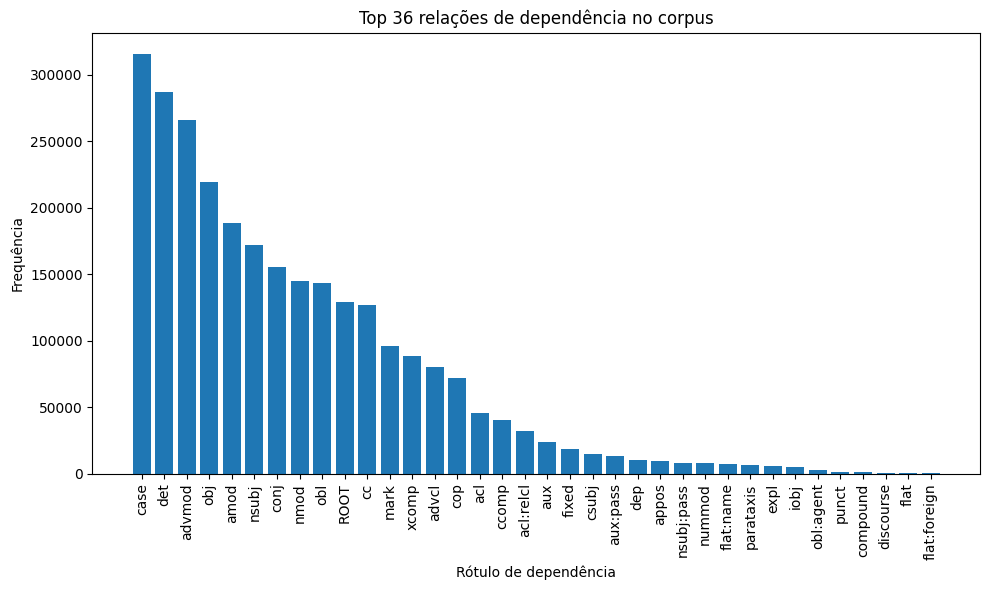

In [73]:
# Plota o gráfico
num_deps = 36

plt.figure(figsize=(10,6))
plt.bar(dep_df["Dep"][:num_deps], dep_df["Freq"][:num_deps])
plt.title(f"Top {num_deps} relações de dependência no corpus")
plt.ylabel("Frequência")
plt.xlabel("Rótulo de dependência")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [69]:
# Mostra visualmente as dependências sintáticas
def show_dependencies(text):
    doc = nlp(text)
    displacy.render(doc, style="dep", options={"distance": 100})

In [77]:
# Demonstração de frases do dataset
sample_idx = [1, 2, 3]  # Índices

for idx in sample_idx:
    sent = df["review_text_clean"].iloc[idx]
    print(f"\n{sent}")
    show_dependencies(sent)
    print("-" * 200)


produto excepcional recomendo inovador e gostoso de ler


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

recebi o produto antes do prazo mas veio com defeito na trava ou seja não da para usar e até agora a americanas não resolveu e preciso muito deste produto


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

bom custo beneficio adequado para pessoas que fazem um uso casual do aparelho a máquina fotográfica é excelente a tela fornece imagens ótimas os recursos do aparelho são fáceis de manejar


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


## Análise Semântica e Classificação de Polaridade Avançada

In [86]:
# URL do SentiLex-PT (versão lematizada)
SENTILEX_URL = "https://raw.githubusercontent.com/sillasgonzaga/lexiconPT/refs/heads/master/data-raw/SentiLex-lem-PT02.txt"

# Carregar o léxico
def load_sentilex():
    response = requests.get(SENTILEX_URL)
    sentilex = defaultdict(int)  # Dicionário com valor padrão 0

    for line in response.text.split('\n'):
        if ';POL:' in line:  # Linhas com polaridade
            word_part, _, polarity = line.partition(';POL:')
            word = word_part.split('.')[0].lower()  # Pega a palavra base (ex: "bom.Adj" → "bom")

            if 'N0=-1' in polarity:  # Termo negativo
                sentilex[word] = -1
            elif 'N0=1' in polarity:  # Termo positivo
                sentilex[word] = 1
    return sentilex

# Criar o dicionário
sentilex = load_sentilex()

In [87]:
# Baixar lista de advérbios intensificadores
url = "https://raw.githubusercontent.com/portlex/resources/main/intensifiers_pt.txt"
response = requests.get(url)
intensifiers_pt = set(response.text.splitlines())

In [88]:
!python -m spacy download pt_core_news_lg --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.2/568.2 MB 3.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [89]:
nlp = spacy.load("pt_core_news_lg")

def semantic_sentiment(text):
    doc = nlp(text)

    # Dicionários de advérbios
    intensifiers = [token.text for token in doc if token.pos_ == "ADV" and token.dep_ in ("advmod", "intj")]
    negators = [token.dep_ for token in doc if token.dep_ == 'neg']

    total_score = 0
    negation = False
    current_intensity = 1.0

    for token in doc:
        # 1. Verifica negações e seu escopo
        if token.text.lower() in negators:
            negation = not negation
            continue

        # 2. Verifica intensificadores
        if token.text.lower() in intensifiers:
            current_intensity += 1
            continue

        # 3. Pega polaridade da palavra
        word_polarity = sentilex.get(token.text.lower(), 0)

        # 4. Aplica negação e intensidade
        if negation:
            word_polarity *= -1
        word_polarity *= current_intensity

        # 5. Considera relações sintáticas (ex: "serviço horrível")
        if token.dep_ in ("amod", "advmod"):  # Adjetivos/advérbios modificadores
            word_polarity *= 1.5
        elif token.dep_ == "nsubj":  # Sujeito tem mais peso
            word_polarity *= 1.2

        total_score += word_polarity

        # Reseta modificadores para a próxima palavra
        current_intensity = 1.0
        negation = False if token.dep_ in ("punct", "cc") else negation

    # Normaliza pelo comprimento do texto
    if len(doc) > 0:
        total_score /= len(doc)

    return total_score

# Aplica a extração de características
print("Extraindo características linguísticas...")
tqdm.pandas(desc="Extração de Features")
df["score"] = df['review_text_clean'].progress_apply(semantic_sentiment).apply(pd.Series)

Extraindo características linguísticas...


Extração de Features:   0%|          | 0/116058 [00:00<?, ?it/s]

In [95]:
def hybrid_pt_sentiment(row):
  if row['score'] > 0:
    return 'positivo'
  else:
    return 'negativo'


Classificando sentimentos...


Classificação:   0%|          | 0/116058 [00:00<?, ?it/s]


Distribuição da classificação híbrida:
hybrid_sentiment
positivo    60935
negativo    55123
Name: count, dtype: int64


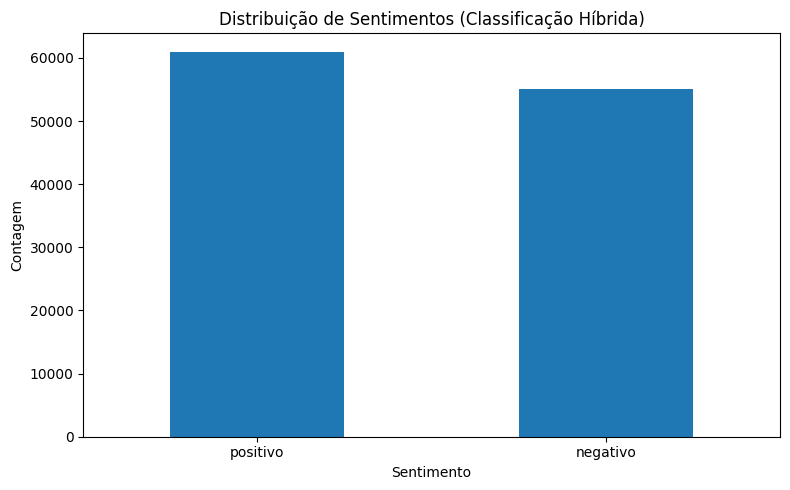

In [96]:
# Aplica a classificação híbrida
print("\nClassificando sentimentos...")
tqdm.pandas(desc="Classificação")
df['hybrid_sentiment'] = df.progress_apply(hybrid_pt_sentiment, axis=1)

# Visualização dos resultados
print("\nDistribuição da classificação híbrida:")
print(df['hybrid_sentiment'].value_counts())

plt.figure(figsize=(8,5))
df['hybrid_sentiment'].value_counts().plot(kind='bar')
plt.title('Distribuição de Sentimentos (Classificação Híbrida)')
plt.xlabel('Sentimento')
plt.ylabel('Contagem')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Acurácia da classificação híbrida vs polaridade original:
Acurácia: 70.85%


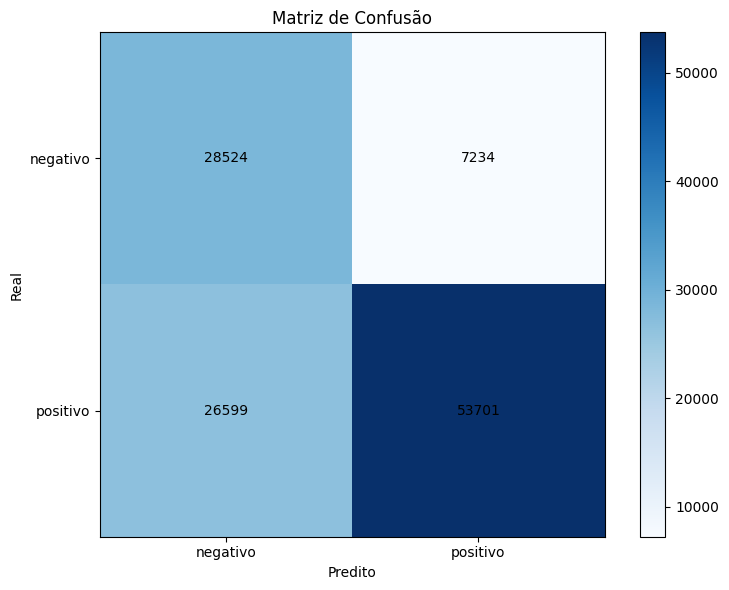


Exemplos de reviews classificadas:

Review: ESTOU AGUARDANDO ENTREGA, NÃO RECEBI O MICROONDAS.
Sentimento: negativo

Review: Comprei pra presentear. Entreguei ontem e veio faltando o copo medidor. Ainda não usamos o produto por esse motivo. Aguardo resposta para esse problema.
Sentimento: negativo

Review: Produto excelente, muito bom para um café da tarde e no dia a dia.
Sentimento: positivo


In [98]:
# Comparação com a polaridade original (se disponível)
if 'polarity' in df.columns:
    print("\nAcurácia da classificação híbrida vs polaridade original:")

    # Converte polaridade original para categorias comparáveis
    df['original_sentiment'] = df['polarity'].apply(lambda x: 'positivo' if x == 1 else 'negativo')

    # Calcula acurácia
    accuracy = (df['hybrid_sentiment'] == df['original_sentiment']).mean()
    print(f"Acurácia: {accuracy:.2%}")

    # Matriz de confusão
    confusion_matrix = pd.crosstab(df['original_sentiment'], df['hybrid_sentiment'],
                                 rownames=['Real'], colnames=['Predito'])
    # Visualização da matriz de confusão
    plt.figure(figsize=(8,6))
    plt.imshow(confusion_matrix, cmap='Blues')
    plt.colorbar()
    plt.xticks(range(len(confusion_matrix.columns)), confusion_matrix.columns)
    plt.yticks(range(len(confusion_matrix.index)), confusion_matrix.index)
    plt.xlabel('Predito')
    plt.ylabel('Real')

    for i in range(len(confusion_matrix.index)):
        for j in range(len(confusion_matrix.columns)):
            plt.text(j, i, confusion_matrix.iloc[i, j], ha='center', va='center', color='black')

    plt.title('Matriz de Confusão')
    plt.tight_layout()
    plt.show()

# Exemplo de reviews com classificação
print("\nExemplos de reviews classificadas:")
sample_reviews = df.sample(3, random_state=100)[['review_text', 'hybrid_sentiment']]
for _, row in sample_reviews.iterrows():
    print(f"\nReview: {row['review_text']}")
    print(f"Sentimento: {row['hybrid_sentiment']}")